### Installing and importing the packages

In [ ]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install pyforest
!pip install lazypredict 

     |████████████████████████████████| 112kB 8.5MB/s 
     |████████████████████████████████| 34.0MB 90kB/s 
     |████████████████████████████████| 13.1MB 238kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=61ec2de1919ebf52059bb5a7ea248f2975391bd0eca3cf5b5f01ff3b53480d31
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 358kB 7.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=5ab2a6c091685c1a97150eb912c67937ee14573fbc1a11693e00c8cb7abdc6dd
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=6cecfd280c686a3c7e781e807586dc91ebe01270d27e97d7fa7106eb1768d54a
  Stored in directory: /root/.cache/pip/wheels/40/c6/da/43562aeea85b37f1a2b3d326f0f602f865000d2ada8a43625f
Successfully built pyforest
     |████████████████████████████████| 127.6MB 49kB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 307kB 54.6MB/s 
     |████████████████████████████████| 14.5MB 242kB/s 
     |████████████████████████████████| 25.9MB 92kB/s 
     |████████████████████████████████| 1.2MB 33.8MB/s 
     |███████████████████████

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

### Understanding the data

In [ ]:
data = pd.read_csv('/content/heart_cleveland_upload.csv')
data.head(5)

age  sex  cp  trestbps  chol  ...  oldpeak  slope  ca  thal  condition
0   69    1   0       160   234  ...      0.1      1   1     0          0
1   69    0   0       140   239  ...      1.8      0   2     0          0
2   66    0   0       150   226  ...      2.6      2   0     0          0
3   65    1   0       138   282  ...      1.4      1   1     0          1
4   64    1   0       110   211  ...      1.8      1   0     0          0

[5 rows x 14 columns]

In [ ]:
data.describe()

age         sex          cp  ...          ca        thal   condition
count  297.000000  297.000000  297.000000  ...  297.000000  297.000000  297.000000
mean    54.542088    0.676768    2.158249  ...    0.676768    0.835017    0.461279
std      9.049736    0.468500    0.964859  ...    0.938965    0.956690    0.499340
min     29.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     48.000000    0.000000    2.000000  ...    0.000000    0.000000    0.000000
50%     56.000000    1.000000    2.000000  ...    0.000000    0.000000    0.000000
75%     61.000000    1.000000    3.000000  ...    1.000000    2.000000    1.000000
max     77.000000    1.000000    3.000000  ...    3.000000    2.000000    1.000000

[8 rows x 14 columns]

In [ ]:
data.shape

(297, 14)

In [ ]:
heart = data.copy()

In [ ]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

### Histogram

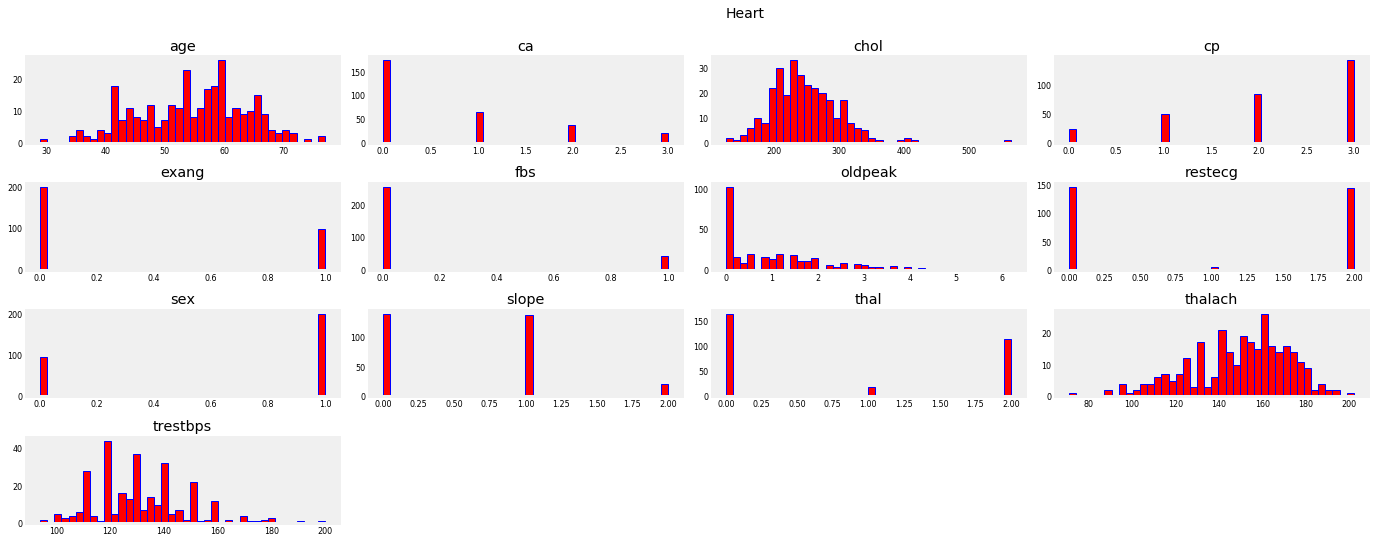

In [ ]:
heart[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Heart', x=0.65, y=1.25, fontsize=14);
plt.savefig("/content/Histogram.png",bbox_inches='tight')
plt.show()

### Correlation heatmap

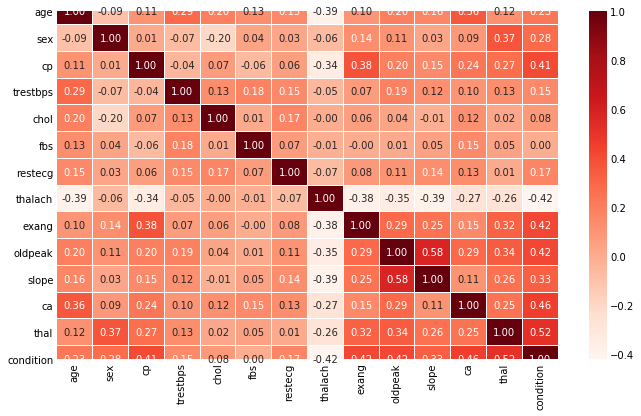

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
corr = heart.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
plt.savefig("/content/Heatmap.png",bbox_inches='tight')
plt.show()

### Using LazyPredict for model selection


In [ ]:
y = heart.pop('condition')

In [ ]:
y.sum() / len(y)

0.4612794612794613

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [ ]:
import pyforest
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:01<00:00, 25.31it/s]


Accuracy  ...  Time Taken
Model                                    ...            
SGDClassifier                      0.93  ...        0.01
LinearSVC                          0.92  ...        0.04
LinearDiscriminantAnalysis         0.92  ...        0.02
RidgeClassifierCV                  0.92  ...        0.01
RidgeClassifier                    0.92  ...        0.02
GaussianNB                         0.92  ...        0.02
NearestCentroid                    0.92  ...        0.02
SVC                                0.90  ...        0.02
CalibratedClassifierCV             0.90  ...        0.07
NuSVC                              0.90  ...        0.02
LogisticRegression                 0.90  ...        0.03
AdaBoostClassifier                 0.90  ...        0.10
LGBMClassifier                     0.90  ...        0.04
KNeighborsClassifier               0.88  ...        0.02
BernoulliNB                        0.90  ...        0.02
ExtraTreeClassifier                0.87  ...        0.01
PassiveAggressiveClassifier        0.88  ...        0.02
Perceptron                         0.88  ...        0.01
QuadraticDiscriminantAnalysis      0.88  ...        0.01
RandomForestClassifier             0.88  ...        0.17
BaggingClassifier                  0.87  ...        0.04
ExtraTreesClassifier               0.87  ...        0.14
XGBClassifier                      0.85  ...        0.19
LabelSpreading                     0.77  ...        0.03
LabelPropagation                   0.77  ...        0.02
DecisionTreeClassifier             0.77  ...        0.01
DummyClassifier                    0.38  ...        0.02

[27 rows x 5 columns]

### LINEAR SVC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm

In [ ]:
clf = svm.SVC(kernel='linear', C = 1.0,probability=True)

In [ ]:
svc_model = clf.fit(X_train,y_train)

In [ ]:
svc_predictions =svc_model.predict(X_test)

In [ ]:
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]


In [ ]:
evaluation_scores(y_test, svc_predictions, )

Accuracy: 0.9
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.97      0.86      0.91        37

    accuracy                           0.90        60
   macro avg       0.89      0.91      0.90        60
weighted avg       0.91      0.90      0.90        60



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.DataFrame(confusion_matrix(y_test, svc_predictions), columns=['Predicted 0', "Predicted 1"], index=['Actual 0', 'Actual 1'])

Predicted 0  Predicted 1
Actual 0           22            1
Actual 1            5           32

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,svc_predictions).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 32
False Positives: 1
True Negatives: 22
False Negatives: 5


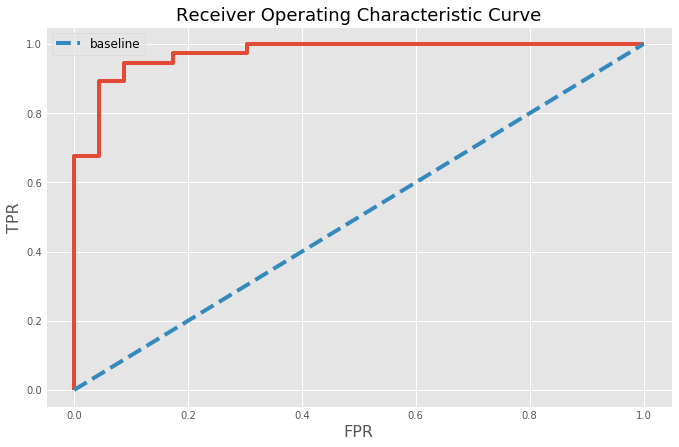

In [ ]:
probas = clf.predict_proba(X_test)[:, 1]

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)
plt.savefig("/content/Receiver Operating Characteristic Curve.png",bbox_inches='tight')
plt.show()

In [ ]:
roc_auc_score(y_test, svc_predictions)

0.91069330199765

Feature Importance:

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
x = eli5.show_weights(svc_model,feature_names= features_list ,top=30)
raw_html = x._repr_html_()
Html_file= open("/content/weights.html","w")
Html_file.write(raw_html)
Html_file.close()
x

In [ ]:
tgt = 4
print('Reference:', y_test.iloc[tgt])
print('Predicted:', svc_predictions[tgt])
x = eli5.show_prediction(clf, X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)
raw_html = x._repr_html_()
Html_file= open("/content/contribution_feature_value.html","w")
Html_file.write(raw_html)
Html_file.close()
x

Reference: 1
Predicted: 1


Permutation Importance:

In [ ]:
permutation = PermutationImportance(clf, random_state=21).fit(X_train, y_train)

In [ ]:
x = eli5.show_weights(permutation, feature_names = features_list, top=30)
raw_html = x._repr_html_()
Html_file= open("/content/weight_feature.html","w")
Html_file.write(raw_html)
Html_file.close()
x

Partial Dependence Plots:

In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False, save_name = "plot.png"):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.savefig(f"/content/{save_name}",bbox_inches='tight')
    plt.show()
    return plt

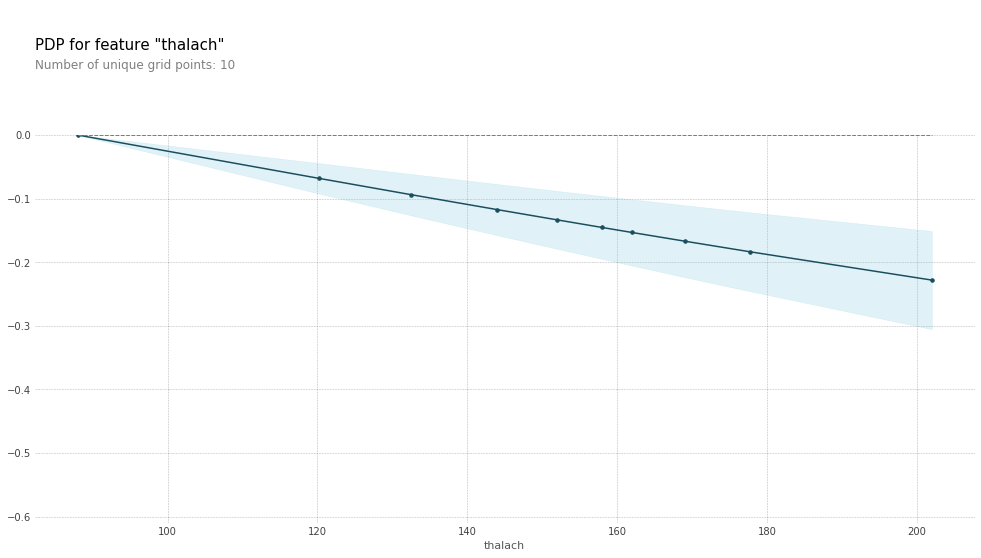

In [ ]:
plt = plot_pdp(svc_model, X_train, 'thalach',save_name="feature_thalach.png")

PDP Interact:

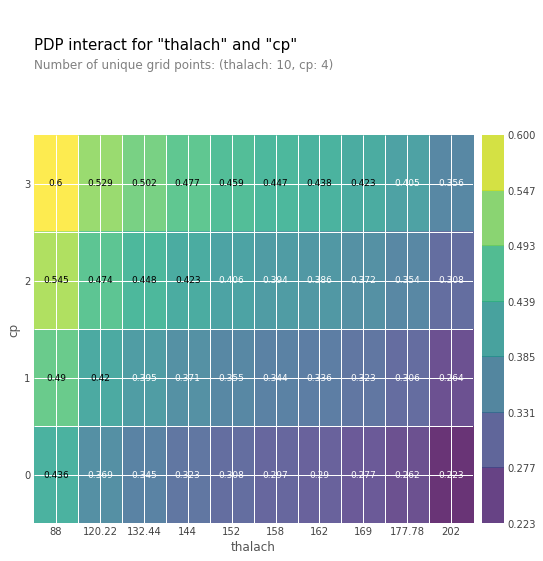

In [ ]:
features_to_plot = ['thalach', 'cp']
inter1  =  pdp.pdp_interact(model=svc_model, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.savefig("PDP interact for thalach and cp.png",bbox_inches='tight')
plt.show()

ICE

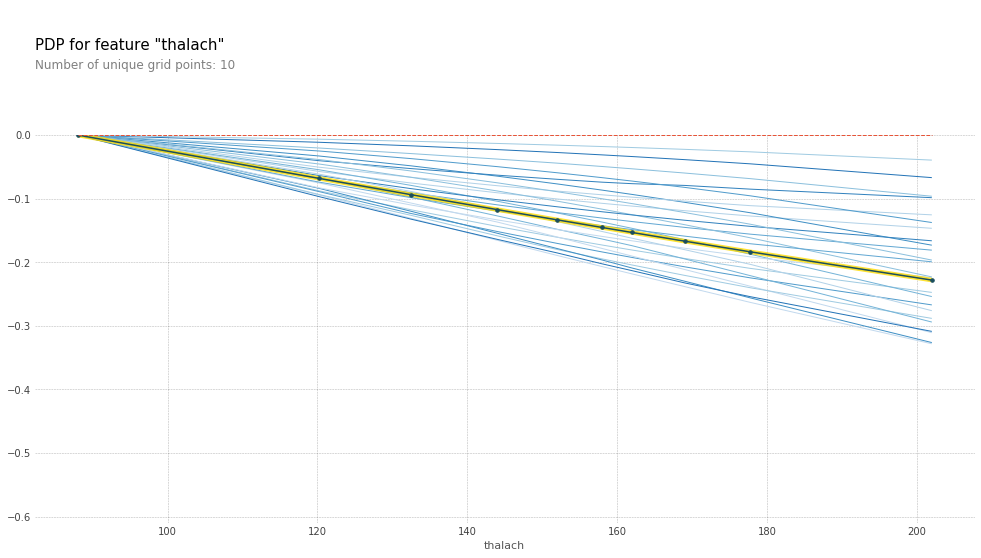

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
plot_pdp(svc_model, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True, save_name="PDP for feature thalach.png")

### XGB

In [ ]:
%%time
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: user 55.4 ms, sys: 0 ns, total: 55.4 ms
Wall time: 42.5 ms


In [ ]:
xgb_predictions = xgb.predict(X_test)

In [ ]:
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

In [ ]:
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.85
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.75      0.91      0.82        23
Hight Quality       0.94      0.81      0.87        37

     accuracy                           0.85        60
    macro avg       0.84      0.86      0.85        60
 weighted avg       0.87      0.85      0.85        60



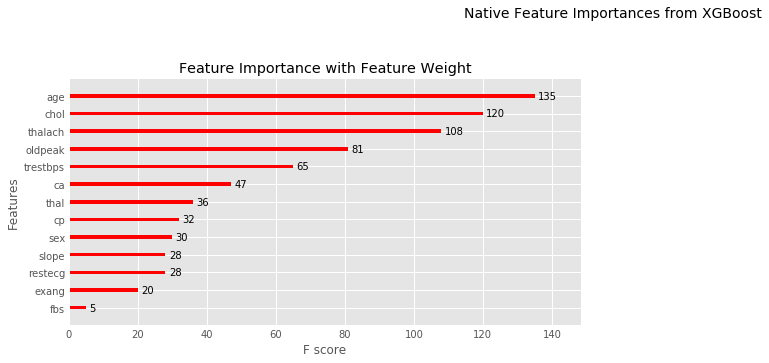

In [ ]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");
fig.savefig("/content/Native Feature Importances from XGBoost.png")

Feature Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
x = eli5.show_weights(xgb.get_booster(), top=30)
raw_html = x._repr_html_()
Html_file= open("/content/weight_feature_xgboost.html","w")
Html_file.write(raw_html)
Html_file.close()
x

In [ ]:
tgt = 4
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
x = eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)
raw_html = x._repr_html_()
Html_file= open("/content/contribution_feature_value_xgboost.html","w")
Html_file.write(raw_html)
Html_file.close()
x

Reference: 1
Predicted: 1


In [ ]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 0
Predicted: 0


In [ ]:
%%time
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

CPU times: user 30.2 ms, sys: 899 µs, total: 31.1 ms
Wall time: 35.6 ms


In [ ]:
model = DecisionTreeClassifier(random_state=1)
model = model.fit(X_train, y_train)

Permutation Importance

In [ ]:
permutation = PermutationImportance(model, random_state=21).fit(X_train, y_train)

In [ ]:
eli5.show_weights(permutation, feature_names = features_list, top=30)

Partial Depedence Plot

In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

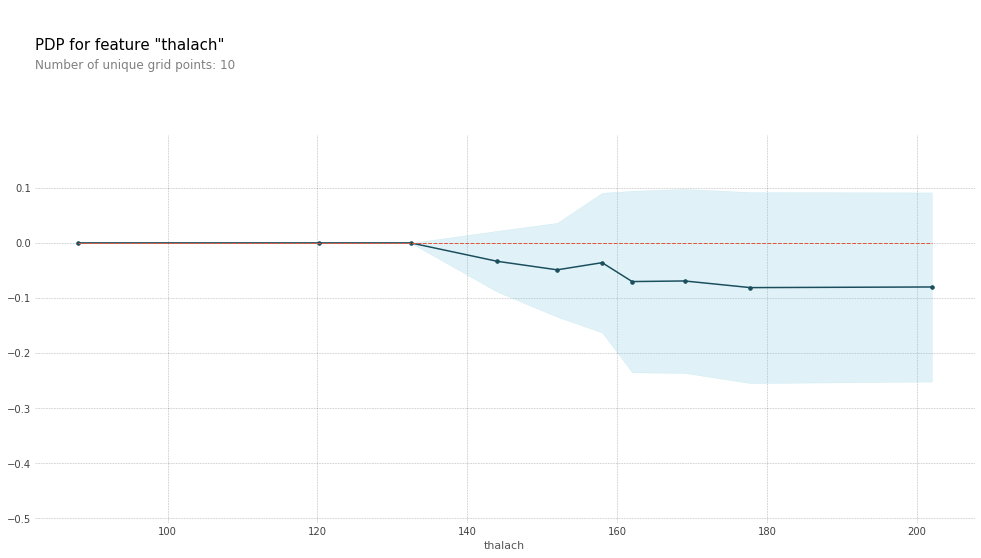

In [ ]:
plot_pdp(xgb, X_train, 'thalach')

PDP Interact

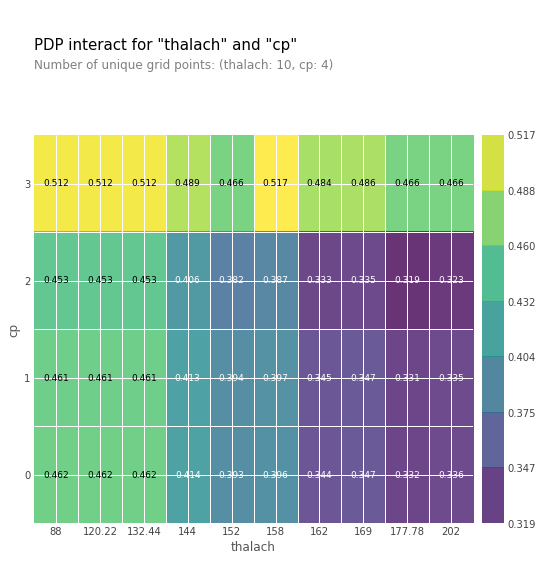

In [ ]:
features_to_plot = ['thalach', 'cp']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

ICE

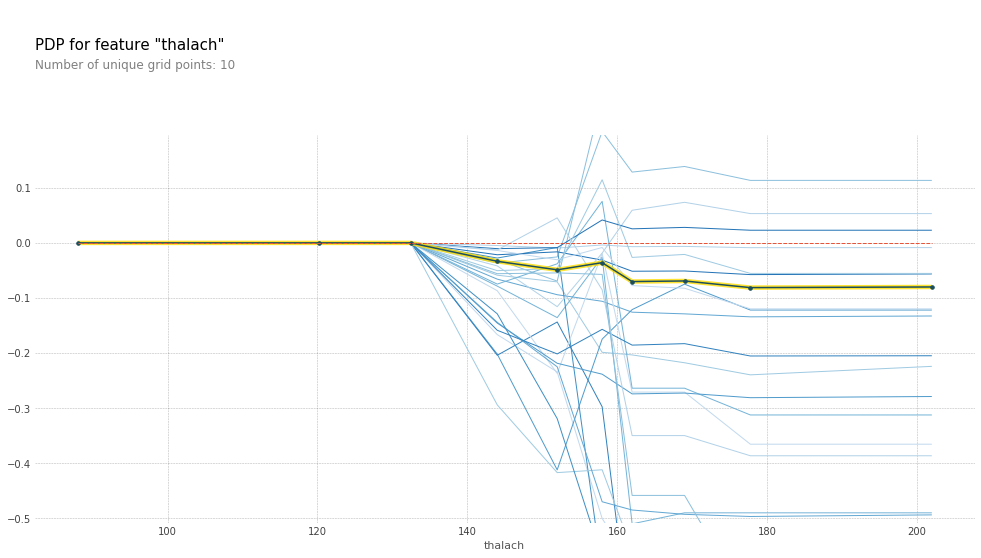

In [ ]:
plot_pdp(xgb, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True)

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)


LIME

In [ ]:
!pip install skater
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['Low Quality', 'High Quality'])

  Using cached https://files.pythonhosted.org/packages/5a/99/aa0b52e709a621dfae9fbf8359c9f1ee6d2272e7f53cd2815284e088ec74/skater-1.1.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/be/8b/4e47893d91d2408028b80815a30f128e840104e5ed10999c0121f5f1a7f3/wordcloud-1.3.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/4f/51/870b2ec270fc29c5d89f85353da420606a9cb39fba4747127e7c7d7eb25d/joblib-0.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/ff/ae64bacdfc95f27a016a7bed8e8686763ba4d277a78ca76f32659220a731/Jinja2-2.10-py2.py3-none-any.whl
  ERROR: Failed building wheel for skater
  Running setup.py clean for skater
  ERROR: Failed building wheel for wordcloud
  Running setup.py clean for wordcloud
Failed to build skater wordcloud
ERROR: librosa 0.8.1 has requirement joblib>=0.14, but you'll have joblib 0.11 which is incompatible.
ERROR: lazypredict 0.2.9 has requirement joblib==1.0.0, but you'll have joblib 0.11 which is incompatible.

ModuleNotFoundError: ignored

In [ ]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0
Predicted: [0.9808606 0.0191394]


In [ ]:
tgt = 4
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.01886982 0.9811302 ]


In [ ]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=33)


In [ ]:
f1 = surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')
print('F1 score for the surrogate tree: ', f1)

2020-08-06 09:16:12,570 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2020-08-06 09:16:12,579 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2020-08-06 09:16:12,844 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (237, 2)
2020-08-06 09:16:12,850 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.872; oracle score 0.979
2020-08-06 09:16:12,852 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.107 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


F1 score for the surrogate tree:  0.107


In [ ]:
# A reminder for referencing the originals feature names 
# since these names are not kept in the surrogate tree
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(heart.columns)]).T

0    1   2         3     4    5   ...       7      8        9      10   11    12
0   X0   X1  X2        X3    X4   X5  ...       X7     X8       X9    X10  X11   X12
1  age  sex  cp  trestbps  chol  fbs  ...  thalach  exang  oldpeak  slope   ca  thal

[2 rows x 13 columns]

SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

0     1     2     3    4    5     6     7     8     9    10    11    12
55  0.07 -1.53 -0.51  0.43 0.79 0.03  0.22 -0.10 -0.27 -0.37 -0.43 -0.99 -1.23
56 -0.62  0.32  0.58 -0.25 0.88 0.05 -0.08  0.84  0.86  0.68  0.36 -1.42 -0.65
57 -0.69 -0.68  0.70  0.53 0.52 0.03  0.08  0.69  0.88  1.28  0.67 -1.55 -1.46
58  0.10  0.30  0.59 -0.78 0.29 0.05 -0.42  0.19  0.61  1.69  0.49  1.42  0.96
59 -0.55 -0.79  0.65  0.04 0.18 0.03 -0.37  0.44 -0.39  1.06  0.68  2.43 -0.73

In [ ]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.4635163


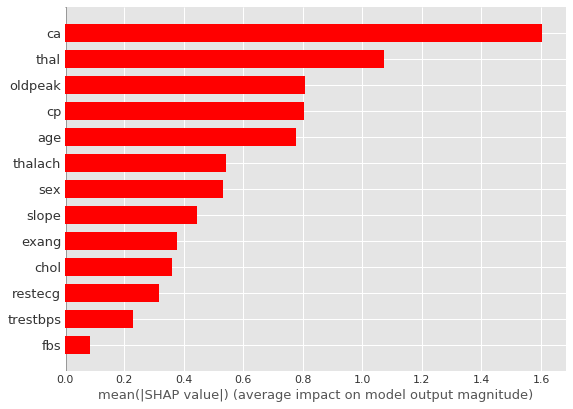

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red', show=False)
plt.savefig("shap1.png",bbox_inches='tight')
plt.show()

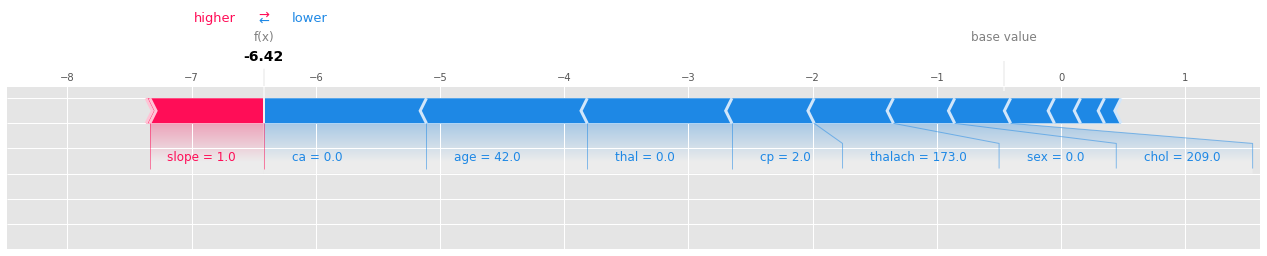

In [ ]:
import matplotlib.pyplot as plt
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:],show=False,matplotlib=True)
plt.savefig("shap2.png",bbox_inches='tight')
plt.show()

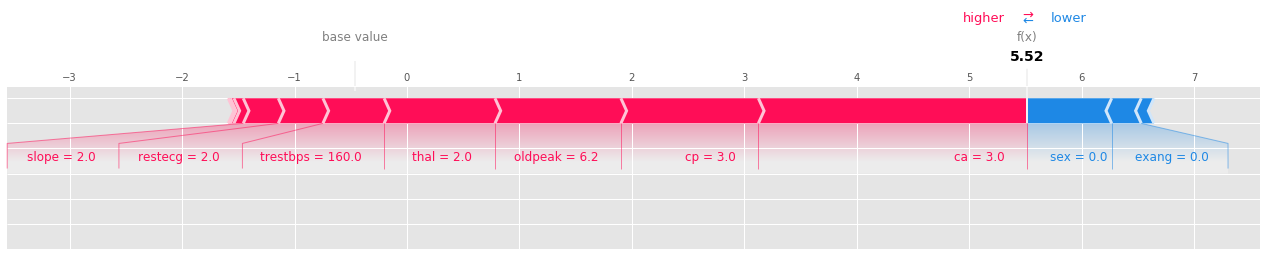

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:],show=False,matplotlib=True)
plt.savefig("shap3.png",bbox_inches='tight')
plt.show()

In [ ]:
#AA NATHI THAYU
shap.initjs()
x = shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:],show=False)
print(x)
# plt.savefig("shap4.png",bbox_inches='tight')
# plt.show()

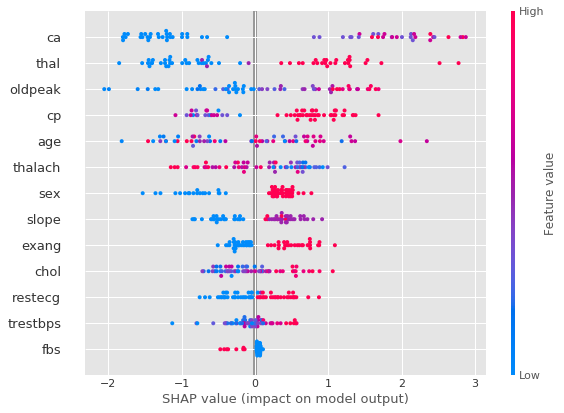

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_sumary.png",bbox_inches='tight')
plt.show()

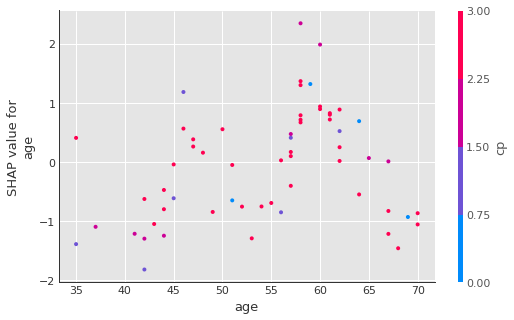

In [ ]:
shap.initjs()
shap.dependence_plot(ind='age', interaction_index='cp',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test, show=False)
plt.savefig("shap_dependence.png",bbox_inches='tight')
plt.show()